# Macroeconomic forecasting: Can machine learning methods outperform traditional approaches?

## 0. Setup of the notebook


### Loading packages and modules

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 250)

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import KNNImputer

from sklearn.model_selection import GridSearchCV

from pmdarima.arima import auto_arima

# pytorch
from torch import nn, no_grad, save, load
from torch import from_numpy, zeros
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, TensorDataset

import torch as T
import torch.nn as nn
import torch.nn.functional as F

# plots
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import seaborn as sns
sns.set_style("darkgrid")

import pickle

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 1. Data

## 1.1 Real gross domestic product 

The gross domestic product (GDP) is the variable of interest.

Source of the data public availabe on the website of the IMF [here](https://www.imf.org/en/Publications/WEO/weo-database/2020/October/download-entire-database) and provided via an Excel file called `WEOApr2020all.xls`.

In [2]:
file = r"C:\Users\hauer\Dropbox\CFDS\Project\data2\WEOApr2020all.csv"
df_weo_real_gdp = pd.read_csv(file)

There are several types of data in this file. This is the description of the relevant subject, the growth of the GDP:

In [3]:
idx = df_weo_real_gdp['Subject Descriptor'] == 'Gross domestic product, constant prices'
df_weo_real_gdp['Subject Notes'] 

df_weo_real_gdp.loc[idx, 'Subject Notes'].unique()

array(['Annual percentages of constant price GDP are year-on-year changes; the base year is country-specific . Expenditure-based GDP is total final expenditures at purchasers? prices (including the f.o.b. value of exports of goods and services), less the f.o.b. value of imports of goods and services. [SNA 1993]'],
      dtype=object)

In [4]:
df_weo_real_gdp.loc[idx, 'Units'].unique()

array(['Percent change'], dtype=object)

The subject code given by the IMF is 'NGDP_RPCH'. This code will also occour in for the weo prediction data. 

In [5]:
df_weo_real_gdp.loc[idx, 'WEO Subject Code'].unique()

array(['NGDP_RPCH'], dtype=object)

As the data for the years are present in the columns of the dataframe, i exctract the relevant information and transpose it afterwars. I want the years as the rows and the variables as the columns. 

In [6]:
df_weo_real_gdp.columns

Index(['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
       'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
       'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', 'Estimates Start After'],
      dtype='object')

This is done with the function: 

In [7]:
def get_imf_woe_data(df_weo_real_gdp, country, remove_na=False):

    df = df_weo_real_gdp[df_weo_real_gdp['Country'] == country]
    
    result = pd.DataFrame()
    
    available_variables = df['Subject Descriptor'].unique()
    
    for variable in available_variables:
        df_curr = df[df['Subject Descriptor'] == variable]
        df_curr = df_curr.iloc[:, 9:49]
        df_curr = df_curr.transpose()
        df_curr = df_curr.rename({df_curr.columns[0]: variable}, axis='columns')
        result = pd.concat([result, df_curr], axis=1)
        
        
    if remove_na:
        result = result.dropna(axis=1) 
        
    return result

To extract the GDP data i use this function: 

In [8]:
def get_gdp_real(df_weo_real_gdp, country):
    df = get_imf_woe_data(df_weo_real_gdp, country, remove_na=False)
    df.index = df.index.astype(dtype='int64')   
    df['GDP real'] = df['Gross domestic product, constant prices']  
    df['GDP real'] = df['GDP real'].str.replace(',', '').astype('float')
    return df['GDP real']

Here is for example the real GDP growth for germany:

In [9]:
get_gdp_real(df_weo_real_gdp, 'Germany')

1980    1.272
1981    0.110
1982   -0.788
1983    1.555
1984    2.826
1985    2.192
1986    2.417
1987    1.469
1988    3.736
1989    3.913
1990    5.723
1991    5.011
1992    1.925
1993   -0.976
1994    2.395
1995    1.541
1996    0.814
1997    1.790
1998    2.019
1999    1.885
2000    2.905
2001    1.689
2002   -0.201
2003   -0.708
2004    1.186
2005    0.728
2006    3.815
2007    2.975
2008    0.965
2009   -5.694
2010    4.185
2011    3.913
2012    0.428
2013    0.431
2014    2.218
2015    1.742
2016    2.230
2017    2.465
2018    1.522
2019    0.565
Name: GDP real, dtype: float64

The real GDP is availabe for the following 195 (one occurrence is Nan) countries: 

In [10]:
countries_woe_real = df_weo_real_gdp['Country'].unique()
len(countries_woe_real)

195

In [11]:
countries_woe_real

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Democratic Republic of the Congo', 'Republic of Congo',
       'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'The Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Gui

## 1.2 The variables X

### 1.2.1 IMF

The IMF proivdes some economic variables along with the realised GDP, that are already in the `df_weo_real_gdp` dataframe:

In [12]:
df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, 'Germany', remove_na=False)
df_imf_woe_data.head()

,"Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product per capita, constant prices","Inflation, average consumer prices","Inflation, end of period consumer prices",Unemployment rate,General government net lending/borrowing,Current account balance
1980,1.272,867.363,0.931,5.447,NaN,3.359,NaN,-1.782
1981,0.11,950.471,-0.078,6.324,NaN,4.831,NaN,-0.684
1982,-0.788,"1,001.24",-0.717,5.256,NaN,6.734,NaN,0.866
1983,1.555,"1,056.63",1.91,3.284,NaN,8.099,NaN,0.666
1984,2.826,"1,125.70",3.243,2.396,NaN,8.058,NaN,1.423


I will use the following quantities:

In [13]:
imf_woe_variables = ['Inflation, average consumer prices', 'Unemployment rate', 'General government net lending/borrowing', 'Current account balance']

for x in imf_woe_variables:
    idx = df_weo_real_gdp['Subject Descriptor'] == x
    print(x)
    print(df_weo_real_gdp.loc[idx, 'Subject Notes'].unique())
    print(df_weo_real_gdp.loc[idx, 'Units'].unique())
    print('')

Inflation, average consumer prices
['Annual percentages of average consumer prices are year-on-year changes.']
['Percent change']

Unemployment rate
['Unemployment rate can be defined by either the national definition, the ILO harmonized definition, or the OECD harmonized definition. The OECD harmonized unemployment rate gives the number of unemployed persons as a percentage of the labor force (the total number of people employed plus unemployed). [OECD Main Economic Indicators, OECD, monthly] As defined by the International Labour Organization, unemployed workers are those who are currently not working but are willing and able to work for pay, currently available to work, and have actively searched for work. [ILO, http://www.ilo.org/public/english/bureau/stat/res/index.htm]']
['Percent of total labor force']

General government net lending/borrowing
['Net lending (+)/ borrowing (?) is calculated as revenue minus total expenditure. This is a core GFS balance that measures the extent to

So only `Inflation, average consumer prices` is given by an annual percentage change, the other variables needs to be transformed later. 

The dataframe for example for germany will look like this:

In [14]:
df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, 'Germany', remove_na=False)
df_imf_woe_data[imf_woe_variables]

,"Inflation, average consumer prices",Unemployment rate,General government net lending/borrowing,Current account balance
1980,5.447,3.359,NaN,-1.782
1981,6.324,4.831,NaN,-0.684
1982,5.256,6.734,NaN,0.866
1983,3.284,8.099,NaN,0.666
1984,2.396,8.058,NaN,1.423
1985,2.084,8.124,NaN,2.662
1986,-0.125,7.834,NaN,4.024
1987,0.242,7.843,NaN,3.709
1988,1.274,7.735,NaN,4.317
1989,2.778,6.79,NaN,4.689


### 1.2.3 OECD

The Organisation for Economic Co-operation and Development (OECD) provied also macroeconomic data in its [iLibrary]( https://www.oecd-ilibrary.org). The indicators can be browsed by theme and I choose 37 to use for my forecast. Each one is available by an `.csv` file. I load all of them together into one dataframe: 

In [15]:
def get_oecd_data(path_oecd, country): 
 
    result = pd.DataFrame()
  
    
    for file_name in os.listdir(path_oecd):
    
        
        file = os.path.join(path_oecd, file_name)
        
        df_orig = pd.read_csv(file)
        unique_subjects = df_orig['SUBJECT'].unique()
    
        
        for subject in unique_subjects:
            
            
            df = df_orig.copy()
            df = df[df['LOCATION'] == country] 
            df = df[df['SUBJECT'] == subject]
            
            # if there is only one unique subject, the name is TOT
            if(len(unique_subjects) == 1):
                subject = file_name[:-4]
            
            
            df = df.rename({df.columns[6]: subject}, axis='columns')
            
            df = df.set_index('TIME')
            
            result = pd.concat([result, df[subject]], axis=1)           
    
    return result

In [16]:
path_oecd = r'C:\Users\hauer\Dropbox\CFDS\Project\data2\OECD'

df_oecd = get_oecd_data(path_oecd, 'USA')
df_oecd.tail()

,Air_Pollution,Crude_oil_production,CurrentAccountBalance,Electricity_generation,ExchangeR,Fertility_rates,GHG,Household_spending,NOMINAL,RENT,...,STINT,Tax_on_corporate_profits,Tax_on_goods_and_services,Tax_on_personal_income,TermsOfTrade,TradeGoodsExport,TradeGoodsImport,TradeServicesExport,TradeServicesImports,Working_age_population
2016,7.37633,446538.263,-2.109880,4119445.000,1.0,1.8,14.9,12769962.0,105.711763,103.772816,...,0.644167,1.949,4.299,10.387,101.649388,1451.022,2187.599,780531.0,511898.0,65.890
2017,7.36365,470360.949,-1.871310,4086002.602,1.0,1.8,14.6,13340354.0,112.336757,107.730991,...,1.152500,1.566,4.223,10.422,101.989233,1546.472,2339.885,830387.0,544836.0,65.628
2018,NaN,NaN,-2.185078,4236927.396,1.0,1.7,NaN,13993281.0,119.426500,111.627442,...,2.188333,0.998,4.303,10.037,102.492082,1665.688,2537.730,862434.0,562069.0,65.364
2019,NaN,NaN,-2.241142,NaN,1.0,NaN,NaN,14544601.0,125.599526,115.765067,...,NaN,0.957,4.296,10.143,NaN,1643.161,2497.532,875825.0,588359.0,NaN
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All of the variables are given absolute values for the specific year, so every variable needs to be transformed afterwards.
There are 182 countries or aggregated country groups available:

In [17]:
countries_oecd = set()

for file_name in os.listdir(path_oecd):
    file = os.path.join(path_oecd, file_name)
    df = pd.read_csv(file)
    countries_current = set(df['LOCATION'].unique())
    
    countries_oecd = countries_oecd.union(countries_current)

    
countries_oecd = list(countries_oecd)
len(countries_oecd)

183

In [18]:
countries_oecd

['G-20',
 'G7M',
 'ZAF',
 'KEN',
 'HTI',
 'BTN',
 'NIC',
 'SWE',
 'CHN',
 'EA19',
 'PHL',
 'BFA',
 'MKD',
 'GTM',
 'TUR',
 'LIE',
 'TTO',
 'ITA',
 'EU28',
 'CAN',
 'SOM',
 'UGA',
 'NAM',
 'EA',
 'TUN',
 'SVK',
 'PRT',
 'DEU',
 'NZL',
 'NOR',
 'SEN',
 'IRN',
 'BHR',
 'GMB',
 'TGO',
 'AZE',
 'ECU',
 'IND',
 'SLV',
 'TZA',
 'G20',
 'COG',
 'IRL',
 'GRC',
 'ESP',
 'CHE',
 'OEU',
 'JPN',
 'BEN',
 'HND',
 'MMR',
 'KOR',
 'MUS',
 'SLE',
 'LBN',
 'BRN',
 'LTU',
 'EU27_2020',
 'DZA',
 'MNG',
 'ZWE',
 'CRI',
 'PAK',
 'EA17',
 'LUX',
 'HRV',
 'SDN',
 'DOM',
 'MAC',
 'ARM',
 'FIN',
 'EST',
 'GNB',
 'OECDE',
 'WLD',
 'OAVG',
 'BWA',
 'GNQ',
 'ERI',
 'AUS',
 'HKG',
 'GBR',
 'BGR',
 'GIN',
 'LKA',
 'BGD',
 'DEW',
 'AUT',
 'KWT',
 'UZB',
 'JOR',
 'AGO',
 'NLD',
 'KHM',
 'ETH',
 'EU',
 'LAO',
 'MLI',
 'IDN',
 'NGA',
 'BEL',
 'POL',
 'MRT',
 'BDI',
 'PRY',
 'ARE',
 'COD',
 'KAZ',
 'THA',
 'LBY',
 'FJI',
 'MOZ',
 'CIV',
 'RWA',
 'BRA',
 'CHL',
 'ALB',
 'VEN',
 'CZE',
 'GEO',
 'MAR',
 'NER',
 'GAB',
 'ROU

Here is the mapping from the ISO country code that used the OECD to the country names that are used by the IMF:

In [19]:
path = r'C:\Users\hauer\Dropbox\CFDS\Project\data2\Mapping_country_codes.csv'
df_country_mapping =  pd.read_csv(path, sep = '\t')

df_country_mapping

,ID,ISO,Country
0,1,AFG,Afghanistan
1,2,ALB,Albania
2,3,DZA,Algeria
3,4,AGO,Angola
4,5,ATG,Antigua and Barbuda
5,6,ARG,Argentina
6,7,ARM,Armenia
7,8,ABW,Aruba
8,9,AUS,Australia
9,10,AUT,Austria


## 1.3  World Economic Outlook 


The International Monetary Fund publishes predictions of the GDP growth in its World Economic Outlook. The data can is taken from [here](https://www.imf.org/en/Publications/WEO/weo-database/2020/October) in the related links Historical WEO Forecasts Database. The data is provided in an Excel file called `WEOhistorical.xlsx`. The IMF publishes the WEO twice a year in spring and in fall. I will use the prediction of the fall, as this closer to the next year and therefore the prediction should be more precise. The data is formated the following: 

| country | year   |F1990ngdp_rpch|
|------|--------|--------------|
|   germany  | 1988  | 4.08 |
|   germany  | 1989  | 2.96 |
|   germany  | 1990  | 1.98 |
|   germany  | 1991  | 2.44 |
|   germany  | 1992  | 3.42 |
|   germany  | 1993  | 3.45 |
|   germany  | 1994  | 3.42 |
|   germany  | 1995  | 3.40 |

This is for example the WEO in fall of 1990 for germany. There are two years of historical data and 6 years of forecast data. The forecast can be found in the column `F1990ngdp_rpch`. This is the same subject code as for the realised GDP. I will only use the forecast for the next year, so for 1990 if will use the predicted growth of the GDP in 1991. I extract the forecast for a certain country and prediciton horizon with the following function. First I load the Excel file into an pandas dataframe:

In [20]:
path = r'C:\Users\hauer\Dropbox\CFDS\Project\data2\WEOhistorical.xlsx'
df_weo =  pd.read_excel(path,sheet_name='ngdp_rpch')

The function for the extraction of the WEO is called `get_predictions_weo`:

In [21]:
def get_predictions_weo(df_weo, country, start_forecast, end_forecast):
       
    df = df_weo[df_weo['country'] == country]
    
    
    for col in df.columns:
        if 'S' in col:
            del df[col] 
            
    del df['WEO_Country_Code']     
    
    
    df = df[df['year'] >= start_forecast]
    
    
    predictions_weo = []
    years = np.arange(start_forecast, end_forecast+1, 1)
    
    for year in years:
       
        df_curr = df[df['year'] == year]
        
        year_WEO = year - 1 
        column = 'F' + str(year_WEO) + 'ngdp_rpch'
        y_pred_year = df_curr[column].values[0]
        
        predictions_weo.append(y_pred_year)
    
    predictions_weo = pd.Series(data = predictions_weo, index = years)
    
    return predictions_weo

Here is for example the WEO for germany for the years 2010 to 2018:


In [22]:
get_predictions_weo(df_weo, country = 'Germany', start_forecast =  2010, end_forecast = 2018)

2010    0.335834
2011    2.021567
2012    1.273123
2013    0.852179
2014    1.399657
2015    1.451330
2016    1.573023
2017    1.425094
2018    1.843451
dtype: float64

The WEO is available from 1980 for the following countries or aggregated country groups:

In [23]:
countries_woe = df_weo['country'].unique()
len(countries_woe)

199

In [24]:
countries_woe

array(['World', 'Advanced Economies', 'United States', 'United Kingdom',
       'Austria', 'Belgium', 'Denmark', 'France', 'Germany', 'San Marino',
       'Italy', 'Luxembourg', 'Netherlands', 'Norway', 'Sweden',
       'Switzerland', 'Canada', 'Japan', 'Euro area', 'Finland', 'Greece',
       'Iceland', 'Ireland', 'Malta', 'Portugal', 'Spain', 'Turkey',
       'Australia', 'New Zealand', 'South Africa',
       'Emerging Market and Developing Economies', 'Argentina', 'Bolivia',
       'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras',
       'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay',
       'Venezuela', 'Antigua and Barbuda', 'Bahamas, The', 'Aruba',
       'Barbados', 'Dominica', 'Grenada', 'Guyana', 'Belize', 'Jamaica',
       'Puerto Rico', 'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Suriname',
       'Trinidad and Tobago', 'Bahrain', 'Cyprus', 'I

# 1.3 Joinig the datasets


Here I join the different data sets to get a dataframe for each country. The data is available from 1980 to 2019 expect for the OECD data sets. These are provided from 1970 to 2017 and hence I filter them to receive the time from 1980 to 2017. I use the pythonic try except block to select only countries, that have an correspondent ISO code in the OECD dataset.
I will save each individual dataframe in a dictionary. For later convenience I also rename the column of the real gdp.

In [25]:
database = {}

availabe_countries_woe = set(countries_woe_real).union(countries_woe)

for country in availabe_countries_woe:
    try:
        iso = df_country_mapping[df_country_mapping['Country'] == country]['ISO']
        iso = iso.values[0]
        
        df_real_gdp = get_gdp_real(df_weo_real_gdp, country)
        df_real_gdp = df_real_gdp[df_real_gdp.index <= 2017]
        
        df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, country, remove_na=False)
        df_imf_woe_data = df_imf_woe_data[imf_woe_variables]
        df_imf_woe_data.index = df_imf_woe_data.index.astype(int)
        df_imf_woe_data = df_imf_woe_data[df_imf_woe_data.index <= 2017]
        
        df_oecd = get_oecd_data(path_oecd, iso)
        df_oecd = df_oecd[df_oecd.index >= 1980]
        df_oecd = df_oecd[df_oecd.index <= 2017]
        
        
        df = pd.concat([df_real_gdp, df_imf_woe_data, df_oecd], axis=1)
        
        df = df.rename(columns={"GDP real": "y"})
        
        database[country] = df

    except Exception as e:
        print('Error' + str(e) + ' for ' + str(country))

Errorindex 0 is out of bounds for axis 0 with size 0 for nan
Errorindex 0 is out of bounds for axis 0 with size 0 for Montenegro, Rep. of
Errorcould not convert string to float: '--' for Mauritania
Errorindex 0 is out of bounds for axis 0 with size 0 for Congo, Democratic Republic of the
Errorcould not convert string to float: '--' for Ethiopia
Errorindex 0 is out of bounds for axis 0 with size 0 for Emerging Market and Developing Economies
Errorindex 0 is out of bounds for axis 0 with size 0 for Advanced Economies
Errorindex 0 is out of bounds for axis 0 with size 0 for Euro area
Errorindex 0 is out of bounds for axis 0 with size 0 for Congo, Republic of
Errorindex 0 is out of bounds for axis 0 with size 0 for Gambia, The
Errorindex 0 is out of bounds for axis 0 with size 0 for Bahamas, The
Errorcould not convert string to float: '--' for Gabon
Errorindex 0 is out of bounds for axis 0 with size 0 for World
Errorindex 0 is out of bounds for axis 0 with size 0 for Iran
Errorindex 0 is o

Now I have 189 dataframes that are ready to be analysed: 

In [26]:
len(database.keys())

189

## Fixing data type

During the later analysis there occured problems with wrong datatypes. For example some vaules where saved as strings: `unsupported operand type(s) for /: 'str' and 'str'`. In this section I fix all kind of this problems. 

Here is a list of the issues which i fix in the same order in the following code: 
* Netherlands could not convert string to float: '--'
* Brazil could not convert string to float: '1,430.72'
* Hungary unsupported operand type(s) for /: 'str' and 'str'


In [27]:
def convert_string_series(x):
    try:
        return x.str.replace(',', '').astype(float)
    
    # this operation only works with string vaules, i was not able to filter the other dtypes
    # (that should only be float) but it did not work. 
    
    except:
        return x


database_fixed = {}


for country in database.keys():
    try: 
        # Netherlands could not convert string to float: '--'
        database_fixed[country] =  database[country].replace('--', np.nan)

        # Brazil could not convert string to float: '1,430.72'
        database_fixed[country] =  database[country].replace(',', '')

        # Hungary unsupported operand type(s) for /: 'str' and 'str'
        database_fixed[country]  = database[country].apply(convert_string_series)
        
       
    except Exception as e:
        print(country + " " + str(e))


database = database_fixed.copy()

## Filitering missing values


In [28]:
variables = database['France'].columns
missing_dict = {var:0 for var in variables}

In [29]:
number_of_observations = 0
for country in database.keys():
    df =  database[country]   
    number_of_observations += df.shape[0]

    for column in df.columns:
        column_current = df[column]
        number_of_missing_observations = sum(column_current.isnull())
        missing_dict[column] += number_of_missing_observations   

In [30]:
df_missing = pd.DataFrame.from_dict(missing_dict, orient='index')
df_missing.columns = ['Number of missing entries']
df_missing['Percent of missing entries'] = df_missing['Number of missing entries'] / number_of_observations * 100
df_missing.sort_values(by='Percent of missing entries', ascending=1)

,Number of missing entries,Percent of missing entries
y,794,11.055416
"Inflation, average consumer prices",819,11.403509
Current account balance,1105,15.385686
Material_consumption,2142,29.824561
TOTMAT,2233,31.091618
General government net lending/borrowing,2309,32.149819
Crude_oil_production,2493,34.711779
GHG,2517,35.045948
NONNRGMAT,3431,47.772208
Unemployment rate,3764,52.408800


How many missing values are there for each country in total:

In [31]:
df_missing_countries = pd.DataFrame(columns=['country', 'Percent of missing entries'])
   


for country in database.keys():
    df =  database[country] 
    N, p = df.shape
    number_of_entries = N * p
    number_of_missing = df.isna().sum().sum()
    percent_of_missing = number_of_missing / number_of_entries
    
    df_missing_countries = pd.concat([pd.DataFrame([[country , percent_of_missing]],
                                                        columns=df_missing_countries.columns),
                                         df_missing_countries],ignore_index=True)


df_missing_countries.sort_values(by='Percent of missing entries', ascending=1)


,country,Percent of missing entries
121,United States,0.053258
85,Canada,0.055138
12,Australia,0.062030
165,New Zealand,0.073308
26,United Kingdom,0.102757
112,France,0.111529
123,Sweden,0.117168
16,Germany,0.117794
71,Spain,0.119048
163,Switzerland,0.122807


Filtering out countries that have more than 50 % missing values: 

In [32]:
database_filtered_countries = {}


for country in database.keys():
    df =  database[country] 
    N, p = df.shape
    number_of_entries = N * p
    number_of_missing = df.isna().sum().sum()
    percent_of_missing = number_of_missing / number_of_entries
    
    if percent_of_missing >= 0.75:
        continue
    
    database_filtered_countries[country] = df
len(database_filtered_countries.keys())

58

Next i want to analyse how many values are missing. So I can decide which of the variables I will use for the models. To get an overview I count the number of missing values for all variables of all countries. To do this, I create a dictionary with all varibales available as keys. Then I only continue with the top 15 columns that are filed with values: 
    
    

In [33]:
variables = database_filtered_countries['France'].columns
missing_dict = {var:0 for var in variables}

number_of_observations = 0
for country in database_filtered_countries.keys():
    df =  database_filtered_countries[country]   
    number_of_observations += df.shape[0]

    for column in df.columns:
        column_current = df[column]
        number_of_missing_observations = sum(column_current.isnull())
        missing_dict[column] += number_of_missing_observations 
        
df_missing = pd.DataFrame.from_dict(missing_dict, orient='index')
df_missing.columns = ['Number of missing entries']
df_missing['Percent of missing entries'] = df_missing['Number of missing entries'] / number_of_observations * 100
df_missing.sort_values(by='Percent of missing entries', ascending=1)

,Number of missing entries,Percent of missing entries
GHG,56,2.540835
Crude_oil_production,60,2.722323
y,134,6.079855
"Inflation, average consumer prices",135,6.125227
Current account balance,151,6.851180
ExchangeR,253,11.479129
Population,266,12.068966
Working_age_population,266,12.068966
Fertility_rates,268,12.159710
Unemployment rate,274,12.431942


Selecting the top 15 columns:

In [34]:
df_missing = df_missing.sort_values(by='Percent of missing entries', ascending=1)

selected_columns = df_missing.index[0:15]
selected_columns.values

array(['GHG', 'Crude_oil_production', 'y',
       'Inflation, average consumer prices', 'Current account balance',
       'ExchangeR', 'Population', 'Working_age_population',
       'Fertility_rates', 'Unemployment rate',
       'Patents_on_environment_technologies', 'PPP', 'TOTMAT',
       'Material_consumption', 'General government net lending/borrowing'],
      dtype=object)

Ordering the columns new, because y has to be in first place and create a new database: 

In [35]:
columns = ['y','GHG', 'Crude_oil_production',
       'Inflation, average consumer prices', 'Current account balance',
       'ExchangeR', 'Population', 'Working_age_population',
       'Fertility_rates', 'Unemployment rate',
       'Patents_on_environment_technologies', 'PPP', 'TOTMAT',
       'Material_consumption', 'General government net lending/borrowing']

database_filtered_columns = {}

for country in database_filtered_countries.keys():
    df = database_filtered_countries[country]
    database_filtered_columns[country] = df[columns]


# Spliting the dataset

The reference for this section is the book "The Elements of Statistical Learning" from Hastie et. al. 

To obtain an accurate Data Science process, it is necessary to split the whole dataset in certain subsets.  This is important for two reasons:

* Model selection: estimating the performance of different models in order to choose the best one. The term model selection also includes the tuning of the hyperparameters, if you define a model as the tupel consisting of the data used for training, the concrete typ of model or algorithm and the hyperparameters of the later. 
* Model assessment: having chosen a final model, estimating its prediction error (generalization error) on new data.

The data is split into a training, validation and test set. The training set is used to fit the model and the validation set is used to calculate the validation error. This error gives an estimate of its prediction error. The test is kept in an "vault" and is brought out only at the very end of the analysis. After using the test set, no changes in any step is allowed. Otherwise the test error will underestimate the true test error. With this test error the selection of the best model is done. 

Another thing in this procedure is very important: Every step in the analysis needs to be performed on the training set only. For example in the next section I will impute missing values. I will fit the algorithim that performes the imputation on the training set and predict the values then for both the training and test set. Otherwise the wrong applicaton of the impuation would also underestimate the validation or test error, because for the imputation there would be more information available than in an real life scenario. New data is completly unseen and only the training data is available for fitting the model in generall. 

This is also noted in the section 7.10.2 The Wrong and Right Way to Do Cross-validation. Even though I am not doing cross validation, this description suits the application in this project. 


I will use the years 2014 - 2017 as the test set. I will calculate  the performance on the very end and after i will not change anythin in the procedure. The years  2010 - 2013 will be the validation set and will be use for tuning the hypterparameter. 

In [36]:
def split_dataset(database):
    database_training = {}
    database_validation = {}
    database_test = {}


    for country in database.keys():


        df = database[country]

        #df_test = df[df.index > 2013]
        #df_validation = df[(df.index > 2009) & (df.index <= 2013)]
        #df_training = df[df.index <= 2009]
        
#         df_test = df[df.index > 2012]
#         df_validation = df[(df.index > 2008) & (df.index <= 2012)]
#         df_training = df[df.index <= 2008]
        
        df_test = df[df.index > 2010]
        df_validation = df[(df.index > 2004) & (df.index <= 2010)]
        df_training = df[df.index <= 2004]

        database_training[country] = df_training
        database_validation[country] = df_validation
        database_test[country] = df_test
        
    return (database_training, database_validation, database_test)


database_training, database_validation, database_test = split_dataset(database_filtered_columns)

### kNN

Example for 'Italy'. knn performes as mean, if all values are NaN. 

In [37]:
database_training['Italy']

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
1980,3.099,6.3,1710.017,21.800,-3.518,0.442318,56.433876,64.578,1.7,7.370,4.77,0.381979,NaN,NaN,NaN
1981,0.557,6.1,1364.214,19.510,-3.532,0.587090,56.501674,65.117,1.6,7.649,5.20,0.414519,NaN,NaN,NaN
1982,0.156,6.0,1640.666,16.460,-2.375,0.698513,56.543539,65.789,1.6,8.288,5.55,0.458879,NaN,NaN,NaN
1983,0.925,5.9,2097.621,14.700,0.305,0.784420,56.564076,66.500,1.5,7.367,3.65,0.508248,NaN,NaN,NaN
1984,3.013,6.0,2128.021,10.740,-0.909,0.907395,56.576719,67.167,1.5,7.833,4.60,0.543343,NaN,NaN,NaN
1985,2.621,6.0,2234.422,8.969,-1.218,0.986143,56.593070,67.560,1.4,8.167,4.81,0.575008,NaN,NaN,NaN
1986,2.710,6.1,2402.574,5.820,0.426,0.769939,56.596157,67.786,1.4,8.867,4.65,0.605866,NaN,NaN,NaN
1987,3.067,6.4,3712.637,4.720,-0.359,0.669364,56.601936,68.022,1.4,9.617,4.48,0.626777,NaN,NaN,NaN
1988,4.029,6.5,4570.496,5.090,-0.894,0.672235,56.629290,68.216,1.4,9.683,4.40,0.645684,NaN,NaN,-10.543
1989,3.252,6.8,4349.144,6.245,-1.605,0.708627,56.671778,68.395,1.3,9.667,5.68,0.659832,NaN,NaN,-10.909


In [38]:
df = database_training['Italy']

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights="uniform")

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
1980,3.099,6.3,1710.017,21.800,-3.518,0.442318,56.433876,64.578,1.7,7.370,4.77,0.381979,2.77092,13.11344,-8.9812
1981,0.557,6.1,1364.214,19.510,-3.532,0.587090,56.501674,65.117,1.6,7.649,5.20,0.414519,2.77092,13.11344,-8.9812
1982,0.156,6.0,1640.666,16.460,-2.375,0.698513,56.543539,65.789,1.6,8.288,5.55,0.458879,2.77092,13.11344,-8.9812
1983,0.925,5.9,2097.621,14.700,0.305,0.784420,56.564076,66.500,1.5,7.367,3.65,0.508248,2.77092,13.11344,-8.9812
1984,3.013,6.0,2128.021,10.740,-0.909,0.907395,56.576719,67.167,1.5,7.833,4.60,0.543343,2.77092,13.11344,-8.9812
1985,2.621,6.0,2234.422,8.969,-1.218,0.986143,56.593070,67.560,1.4,8.167,4.81,0.575008,2.77092,13.11344,-8.9812
1986,2.710,6.1,2402.574,5.820,0.426,0.769939,56.596157,67.786,1.4,8.867,4.65,0.605866,2.77092,13.11344,-8.9812
1987,3.067,6.4,3712.637,4.720,-0.359,0.669364,56.601936,68.022,1.4,9.617,4.48,0.626777,2.77092,13.11344,-8.9812
1988,4.029,6.5,4570.496,5.090,-0.894,0.672235,56.629290,68.216,1.4,9.683,4.40,0.645684,2.80044,12.88398,-10.5430
1989,3.252,6.8,4349.144,6.245,-1.605,0.708627,56.671778,68.395,1.3,9.667,5.68,0.659832,2.75428,12.78984,-10.9090


For the validation and training set the `transform` function is also applied to impute missing values for these datapoints: 

In [39]:
df = database_validation['Italy']
df_data = imputer.transform(df)
df_validation = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df_validation

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
2005,0.818,7.8,6109.832,2.207,-0.883,0.803800,57.969482,66.182,1.3,7.683,6.88,0.855139,2.8184,14.3245,-4.083
2006,1.791,7.7,5767.898,2.229,-1.476,0.796433,58.143980,65.907,1.4,6.792,7.58,0.823835,2.8100,14.5596,-3.617
2007,1.487,7.5,5858.880,2.025,-1.367,0.729672,58.438309,65.761,1.4,6.125,8.94,0.810223,2.9258,14.1416,-1.340
2008,-0.962,7.2,5219.003,3.492,-2.795,0.679923,58.826733,65.673,1.4,6.742,10.30,0.783694,3.0210,13.5238,-2.564
2009,-5.281,6.4,4550.130,0.765,-1.885,0.716958,59.095367,65.553,1.4,7.733,11.72,0.770581,3.2094,12.0204,-5.121
2010,1.713,6.6,5079.029,1.620,-3.295,0.754309,59.277414,65.459,1.4,8.350,11.01,0.772612,3.3746,11.5846,-4.240


In [40]:
df = database_test['Italy']
df_data = imputer.transform(df)
df_test = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df_test

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
2011,0.707,6.4,5282.990,2.935,-2.825,0.718414,59.379446,65.291,1.4,8.392,11.06,0.758687,3.3574,11.6746,-3.593
2012,-2.981,6.1,5395.969,3.315,-0.231,0.778338,59.539725,64.994,1.4,10.683,11.71,0.747731,3.8045,9.9469,-2.945
2013,-1.841,5.6,5500.949,1.245,1.109,0.752945,60.233944,64.761,1.4,12.133,10.53,0.737299,4.4085,8.3859,-2.854
2014,-0.005,5.3,5763.898,0.234,1.899,0.752728,60.789144,64.578,1.4,12.608,10.26,0.739644,4.4308,8.3097,-2.954
2015,0.778,5.4,5470.000,0.108,1.421,0.901296,60.730585,64.388,1.4,11.917,10.15,0.738495,4.6079,8.0301,-2.552
2016,1.293,5.4,3746.000,-0.050,2.594,0.903421,60.627494,64.238,1.3,11.667,9.90,0.700615,4.6541,8.0420,-2.404
2017,1.668,5.3,4098.000,1.326,2.575,0.885206,60.536713,64.124,1.3,11.267,10.15,0.686535,4.7564,7.9989,-2.445


Finally this step is done for the whole dataset: 

In [41]:
database_training_imputed = {}
database_validation_imputed = {}
database_test_imputed = {}

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights="uniform")

for country in database_filtered_columns.keys():   
  
    try:
        
        df_current = database_training[country]
        imputer.fit(df_current)
        df_data = imputer.transform(df_current)
        database_training_imputed[country] = pd.DataFrame(data = df_data,
                                                          columns = df_current.columns,
                                                          index = df_current.index)
        
        df_current = database_validation[country]
        df_data = imputer.transform(df_current)
        database_validation_imputed[country] = pd.DataFrame(data = df_data,
                                                            columns = df_current.columns,
                                                            index = df_current.index)
        
        df_current = database_test[country]
        df_data = imputer.transform(df_current)
        database_test_imputed[country] = pd.DataFrame(data = df_data,
                                                      columns = df_current.columns,
                                                      index = df_current.index)
        
    except Exception as e:
        print(country + " " + str(e))
    

Hong Kong SAR Shape of passed values is (25, 10), indices imply (25, 15)
Bulgaria could not convert string to float: '--'
Jamaica Shape of passed values is (25, 10), indices imply (25, 15)
Norway Shape of passed values is (25, 13), indices imply (25, 15)
Paraguay Shape of passed values is (25, 10), indices imply (25, 15)
Zambia Shape of passed values is (25, 11), indices imply (25, 15)
Malaysia Shape of passed values is (25, 10), indices imply (25, 15)
Morocco Shape of passed values is (25, 12), indices imply (25, 15)
Peru Shape of passed values is (25, 13), indices imply (25, 15)
Netherlands could not convert string to float: '--'
Singapore Shape of passed values is (25, 13), indices imply (25, 15)
India Shape of passed values is (25, 14), indices imply (25, 15)


## Preprocess Data

The different variables have different absolute vaules. Some machine learning models will have problems with this type of input. That is the reason I preprocess the data as follows:

First I want to have only growth rates. For a time series $ X = (x_{1}, ..., x_{n})$ the growth rate for $x_{i}$ is defined as:

\begin{equation}
\hat{x}_{i} = \frac{x_{i}}{x_{i-1}}
\end{equation}
    
The first value of the original serires will not be mapped. Another issue occoures when using only this transformation. I compare a 10 % increase and a 10 % decrease of a certain vaule. Let's denothe the increase with $\hat{x}_{I}$ and the decrease with $\hat{x}_{D}$. Now the following applies:

\begin{equation}
\hat{x}_{I} = 1.1 \\
\hat{x}_{D} = 0.9
\end{equation}
 
 so
 
 \begin{equation}
|\hat{x}_{I}| \neq |\hat{x}_{D}|.
\end{equation}

In order to obation the same absolute value for both directions, I will apply a logarithmic transformation:

\begin{equation}
\hat{x}_{i} = \ln(\frac{x_{i}}{x_{i-1}})
\end{equation}

To avoid arguments that are not defined for the logarithm I shift the fraction by $|\min_i(x_{i})|  + 0.001$:
 
\begin{equation}
\hat{x}_{i} = \ln(\frac{x_{i}}{x_{i-1}} + |\min_i(x_{i})| + 0.001)
\end{equation}

In same cases there is $x_{i} = x_{i-1} = 0$ which will cause an error because of divisin by zero. I add a some constant to avoid this problem.  

As there are no statistics from the dataset involved, this transformation can be appplied to the whole dataset. Therefore I first glue the training, validation and test dataset together:

In [42]:
def combine_datasets(database_training, database_validation, database_test):
    database_complete = {}

    for country in database_training.keys():
        database_complete[country] = database_training[country].append(database_validation[country]).append(database_test[country])
        
    return database_complete

database_imputed = combine_datasets(database_training_imputed, database_validation_imputed, database_test_imputed)

With this function I transform the whole dataframe

In [43]:
def convert_time_series_to_relative(df):
    # Assings each t the Values of ln(X_t / X_(t-1))
    # X_0 will be dropped
    
    df_new = df.iloc[1:, :].copy()
    
    for variable in df.columns:
        try:
            
            if not (df[variable] != 0).all():
                df[variable] = df[variable] + 0.001
                
            #Check if this tranformation is correct!
           # df_new[variable] = df[variable].iloc[:-1].values / df[variable].iloc[1:].values
            df_new[variable] = df[variable].iloc[1:].values / df[variable].iloc[:-1].values 
            
            df_new[variable] = np.log(df_new[variable] + 0.001 + np.abs(np.min(df_new[variable])))
        except Exception as e:
            print(country + " " + str(e))
        
    return df_new

and apply it to the database

In [44]:
database_transformed = {}

for country in database_imputed.keys():
    
    database_transformed[country] = convert_time_series_to_relative(database_imputed[country])
  

## Index Shift of the data

reference: paper crystal ball; shifting index for supervised learning, tuples look like (x_t-1, y_t)

In [45]:
def preprocess_for_supervised_learning(df):
     
    df_y = df.loc[:, 'y']
    df_variables = df.drop(['y'], axis=1)
    
    df_variables.index = df_variables.index - 1 
   
    df = pd.DataFrame(df_y).join(df_variables, how='inner')
    
    return df


df = database_transformed['Germany']
df_supervised = preprocess_for_supervised_learning(df)
df_supervised.head()

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
1981,1.981155,0.632298,0.616743,1.018168,1.354160,0.594607,0.683946,0.697905,0.624690,0.806413,0.633409,0.661480,0.656005,0.660662,0.368417
1982,-6.907755,0.660700,0.622615,0.940714,1.776416,0.582665,0.683105,0.697649,0.588342,0.717180,0.636903,0.663734,0.656005,0.660662,0.368417
1983,1.646981,0.668897,0.631374,0.980804,1.984612,0.616934,0.682684,0.696084,0.624690,0.610245,0.640212,0.661181,0.656005,0.660662,0.368417
1984,2.195223,0.660570,0.649201,1.032039,1.947378,0.572700,0.683299,0.693316,0.624690,0.617418,0.705977,0.664048,0.656005,0.660662,0.368417
1985,2.071950,0.660539,0.632125,0.629685,1.894802,0.389478,0.684657,0.691693,0.624690,0.593464,0.669449,0.674149,0.656005,0.660662,0.368417


In [46]:
df.head()

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
1981,1.981155,0.640923,0.621216,1.130759,1.708998,0.684085,0.685195,0.697405,0.590653,0.826003,0.644128,0.644167,0.656005,0.660662,0.368417
1982,-6.907755,0.632298,0.616743,1.018168,1.354160,0.594607,0.683946,0.697905,0.624690,0.806413,0.633409,0.661480,0.656005,0.660662,0.368417
1983,1.646981,0.660700,0.622615,0.940714,1.776416,0.582665,0.683105,0.697649,0.588342,0.717180,0.636903,0.663734,0.656005,0.660662,0.368417
1984,2.195223,0.668897,0.631374,0.980804,1.984612,0.616934,0.682684,0.696084,0.624690,0.610245,0.640212,0.661181,0.656005,0.660662,0.368417
1985,2.071950,0.660570,0.649201,1.032039,1.947378,0.572700,0.683299,0.693316,0.624690,0.617418,0.705977,0.664048,0.656005,0.660662,0.368417


Applying it to the whole database:

In [47]:
database_supervised = {}

for country in database_transformed.keys():
    
    database_supervised[country] = preprocess_for_supervised_learning(database_transformed[country])

Finally I split the dataset again to obtain the training, validation and test sets:

In [48]:
database_training, database_validation, database_test = split_dataset(database_transformed)
database_training_sv, database_validation_sv, database_test_sv = split_dataset(database_supervised)

## Standardization 

Finally, transform data so that every colun has 0 mean and sdtdev 1. This is especially important for neural networks.  

In [49]:
def standardization(df_training, df_validation, df_test):
     
    scaler = preprocessing.StandardScaler().fit(df_training)
    
    return scaler.transform(df_training), scaler.transform(df_validation), scaler.transform(df_test), scaler

Applying it to the whole dataset and keeping track of the scaler instance for each country:

In [50]:
database_training_sv_standard = {}
database_validation_sv_standard = {}
database_test_sv_standard = {}
database_scaler = {}

for country in database_training_sv.keys():
    
    tr, val, test, scaler = standardization(database_training_sv[country], database_validation_sv[country], database_test_sv[country])
    
    database_training_sv_standard[country] = pd.DataFrame(tr)
    database_validation_sv_standard[country] = pd.DataFrame(val)
    database_test_sv_standard[country]  = pd.DataFrame(test)
    database_scaler[country] = scaler
    
    

I also serialize the whole database, so I can start coding without rerunning the whole data handling.

In [51]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database_new.pickle')
with open(database_dir, 'wb') as f:
    save = {
        'database_training': database_training,
        'database_validation': database_validation,
        'database_test': database_test,
        'database_training_sv': database_training_sv,
        'database_validation_sv': database_validation_sv,
        'database_test_sv': database_test_sv,
        
        'database_training_sv_standard': database_training_sv_standard,
        'database_validation_sv_standard': database_validation_sv_standard,
        'database_test_sv_standard': database_test_sv_standard,
        
        'database_scaler': database_scaler,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)

In [52]:
with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

# Models

Loss function: MSE. To determine a to determine a good choise for the hyperparameter, a grid search is done for some of the models. 

List of all models I will use: 

In [53]:
models = []

For models that are in the sklearn framework with the `fit` and `predict` methods, I use this function to perform the evaulation: 

In [54]:
def forecast(model, df_training, df_prediction):
   
    X_train = df_training.iloc[:,1:].values
    y_train = df_training.iloc[:,0].values
    
    X_test = df_prediction.iloc[:,1:].values
    # y_test = df_prediction.iloc[:,0].values
    
    model.fit(X_train, y_train)
    
    y_predicted = model.predict(X_test)
  
    result = pd.Series(data=y_predicted, index = df_prediction.index)
    
    return result

In [55]:
country = 'France'

df_training = database_training[country]
df_validation = database_validation[country]
df_test = database_test[country]

df_training_sv = database_training_sv[country]
df_validation_sv = database_validation_sv[country]
df_test_sv = database_test_sv[country]


t_forecast_test = df_test_sv.index.values

start_forecast = df_validation_sv.index.values[0]
t_forecast_validation = df_validation_sv.index.values

In [56]:
#Check forecasting for supervised learning in the evaliation. values from 2011 forecast value for 2012 

print(start_forecast)
print(t_forecast_validation)
print(t_forecast_test)


2005
[2005 2006 2007 2008 2009 2010]
[2011 2012 2013 2014 2015 2016]


In [57]:
df_training_sv

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
1981,2.473053,0.609451,0.601519,-0.071137,2.015016,0.683670,0.697584,0.694394,0.665490,0.675237,0.586405,0.702128,0.653645,0.637485,0.592842
1982,2.610877,0.608494,0.616214,-0.195111,1.654946,0.658284,0.697287,0.693936,0.638064,0.584808,0.532961,0.701856,0.653645,0.637485,0.423063
1983,2.464965,0.607449,0.735256,-0.169405,1.608607,0.651544,0.697035,0.693557,0.665490,0.705702,0.628229,0.691001,0.642950,0.621882,0.535152
1984,2.524740,0.614790,0.752457,-0.232184,1.662042,0.587784,0.697066,0.691691,0.665490,0.646200,0.563710,0.685382,0.611977,0.648545,0.540708
1985,2.512819,0.614245,0.671075,-0.758447,-6.907755,0.433510,0.697091,0.690409,0.665490,0.641737,0.604574,0.689206,0.643062,0.643581,0.534545
1986,2.542200,0.622645,0.664090,0.283941,1.181913,0.494493,0.697216,0.690698,0.665490,0.647443,0.585682,0.674044,0.653645,0.637485,0.231850
1987,2.514784,0.622493,0.631039,-0.157608,1.755524,0.566952,0.697352,0.690644,0.665490,0.613022,0.632041,0.672481,0.653645,0.637485,0.643985
1988,2.574058,0.649718,0.593164,0.902202,1.760519,0.611326,0.697439,0.690219,0.665490,0.622512,0.568002,0.671008,0.653645,0.637485,0.282147
1989,2.500086,0.622645,0.573785,-2.499423,1.878428,0.485695,0.697248,0.689511,0.665490,0.612577,0.632082,0.668777,0.634775,0.649842,0.691569
1990,2.479959,0.666965,0.598276,2.358763,1.696108,0.592210,0.709726,0.688703,0.665490,0.644743,0.665755,0.670004,0.647338,0.647157,0.591789


In [58]:
df_validation_sv

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
2005,2.472775,0.613357,0.599137,0.034992,1.982254,0.566827,0.698170,0.690696,0.692185,0.627076,0.680650,0.662556,0.654913,0.645666,0.306906
2006,2.544771,0.612713,0.568724,-0.124593,1.486871,0.523548,0.697776,0.690326,0.665490,0.578999,0.696096,0.670667,0.646221,0.654759,0.536216
2007,2.506168,0.621832,0.611837,0.692215,2.455300,0.532774,0.697476,0.689533,0.665490,0.595478,0.640012,0.669637,0.665776,0.623750,0.625513
2008,2.431226,0.611656,0.568061,-2.734537,1.725731,0.602292,0.697257,0.689084,0.665490,0.740770,0.692717,0.662656,0.696727,0.577979,1.039990
2009,-6.907755,0.631547,0.609468,2.847283,1.786752,0.600992,0.697158,0.689151,0.665490,0.640827,0.634489,0.669343,0.674039,0.624392,0.464254
2010,2.359842,0.600388,0.610675,0.300099,1.823267,0.544789,0.697144,0.688140,0.665490,0.628213,0.647360,0.666520,0.649784,0.650087,0.321705


In [59]:
df_test_sv

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
2011,2.517120,0.642341,0.556448,-0.000240,1.783357,0.618015,0.697144,0.686970,0.665490,0.662850,0.646460,0.675906,0.670051,0.619865,0.468260
2012,2.434525,0.620855,0.601822,-0.733306,1.678011,0.553429,0.697264,0.686972,0.665490,0.660214,0.592711,0.654219,0.655266,0.636155,0.372171
2013,2.573217,0.575758,0.592631,-0.429025,1.902243,0.571851,0.698824,0.686839,0.665490,0.630214,0.600781,0.671563,0.664852,0.628741,0.461931
2014,2.559348,0.643561,0.659005,-1.714683,1.650836,0.677629,0.696501,0.687477,0.639453,0.635429,0.603573,0.674703,0.685897,0.609256,0.444213
2015,2.520265,0.631547,0.598197,1.230182,1.815972,0.573343,0.696023,0.688117,0.665490,0.614274,0.567547,0.656093,0.671279,0.623806,0.475034
2016,2.505648,0.643295,0.571897,1.346201,1.839840,0.560569,0.695804,0.688365,0.665490,0.597859,0.635782,0.665148,0.624845,0.678411,0.345922


## WOE

In [60]:
name = 'WOE'
y_forecast = get_predictions_weo(df_weo, country = country,
                                 start_forecast =  t_forecast_validation[0],
                                 end_forecast = t_forecast_validation[-1])
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## OLS

The ordinary least squares regression is the most famous and basic model in econometrics. The depentend variable is shown as:

\begin{equation}
y = x_1\beta_1 + x_2\beta_2 + ... x_N\beta_N + \beta_{N+1}
\end{equation}

In [61]:
name = 'OLS'
model = LinearRegression()
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## ARIMA

The autoregressive integrated moving average ARIMA($p$, $d$, $q$) model is used in time series analysis.

\begin{equation}
X_t - \alpha_1X_{t-1} - ... - \alpha_pX_{t-p} =  \epsilon_t + \theta_1\epsilon_{t-1} + ... + \theta_q\epsilon_{t-q}
\end{equation}

Here $\alpha _{i}$ are the parameters of the autoregressive part of the model, $\theta _{i}$ are the parameters of the moving average part, $d$ is the degree of differencing and $\epsilon _{t}$ are error terms. There is an implementaion in python in the pmdarima package, which automatically discovers the optimal order for an ARIMA model with exogenous variables. 

In [62]:
name = 'ARIMA'

y_train = df_training_sv.iloc[:, 0]
X_train = df_training_sv.iloc[:, 1:]
y_validation = df_validation_sv.iloc[:, 0]
X_validation = df_validation_sv.iloc[:, 1:]

model = auto_arima(y = y_train,
                   trace=True, 
                   start_p=0,
                   max_p=3,
                   start_q=0,
                   max_q=3,
                   seasonal = False,
                   stepwise= True,
                   exogenous=X_train) 

model.fit(y= y_train, exogenous=X_train)

y_forecast = model.predict(n_periods=y_validation.shape[0],
                      exogenous = X_validation)
mse = mean_squared_error(y_forecast, y_validation)
models.append( (name, y_forecast, mse))

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=-16.186, BIC=2.663, Fit time=0.105 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=-14.909, BIC=5.118, Fit time=6.372 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(0, 0, 1); AIC=-21.023, BIC=-0.996, Fit time=1.830 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=-18.993, BIC=2.212, Fit time=7.311 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=-24.644, BIC=-3.439, Fit time=8.148 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=-29.248, BIC=-5.687, Fit time=8.674 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=-31.335, BIC=-8.952, Fit time=7.431 seconds
Total fit time: 39.875 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Elastic Net 

In [63]:

parameters = {'alpha': [0.1, 0.25, 1.0, 2.0, 4.0, 8.0, 16, 32, 128]}
model = Lasso()

clf = GridSearchCV(model, parameters)

X_train = df_training_sv.iloc[:,1:].values
y_train = df_training_sv.iloc[:,0].values


clf.fit(X_train, y_train)

print(clf.best_params_)

{'alpha': 0.1}


In [64]:
name = 'LASSO'
model = Lasso(alpha = 0.1)
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## Support Vector Regression

https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html  

In [65]:
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.25, 1.0, 2.0, 4.0, 8.0],
             'epsilon': [0.01, 0.05, 0.1, 0.25, 0.5]}
model = SVR()
clf = GridSearchCV(model, parameters)

X_train = df_training_sv.iloc[:,1:].values
y_train = df_training_sv.iloc[:,0].values


clf.fit(X_train, y_train)

print(clf.best_params_)

{'C': 0.1, 'epsilon': 0.05, 'kernel': 'sigmoid'}


In [66]:
name = 'SVR'
model = SVR(C=0.1, epsilon=0.05, kernel = 'sigmoid')
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## Regression Tree

In [67]:
parameters = {'max_depth': [2,3,4,5,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
     'min_impurity_decrease': [0.0001, 0.001, 0.01, 0.01] }
model = DecisionTreeRegressor()
clf = GridSearchCV(model, parameters)

X_train = df_training_sv.iloc[:,1:].values
y_train = df_training_sv.iloc[:,0].values


clf.fit(X_train, y_train)

print(clf.best_params_)

{'max_depth': 2, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [68]:
name = 'Tree'
model = DecisionTreeRegressor(max_depth = 2,
                              min_impurity_decrease =  0.0001, 
                              min_samples_leaf = 10,
                              min_samples_split =  2)
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## GBM 

In [69]:
parameters = {'n_estimators':[5, 10, 20, 50, 100], 
              'max_depth':[1, 2, 4],
             'learning_rate': [0.01, 0.03, 0.1, 0.25],
             'min_samples_split':[2, 10]}
model = GradientBoostingRegressor()
clf = GridSearchCV(model, parameters)

X_train = df_training_sv.iloc[:,1:].values
y_train = df_training_sv.iloc[:,0].values


clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [70]:
print(clf.best_params_)

{'learning_rate': 0.01, 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 5}


In [71]:
name = 'GBM'
model = GradientBoostingRegressor(n_estimators = 5, max_depth = 2, 
                                  min_samples_split=2, learning_rate = 0.01)
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))


## RNN

see Notebook 02.

# Evaluation

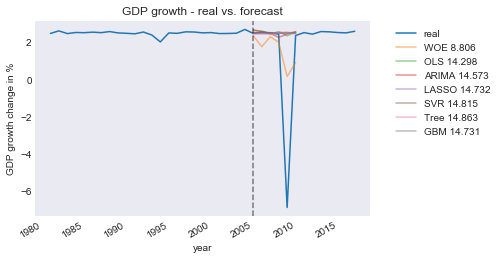

In [72]:
df = database_training[country].append(database_validation[country]).append(database_test[country])

fig, ax = plt.subplots()

ax.plot(df['y'], label='real')

for model in models:
    name = model[0]
    y_forecast = model[1]
    mse = model[2]
    
    label = name + ' ' + str(round(mse,3))
    
    ax.plot(t_forecast_validation,  y_forecast, label=label, alpha=0.5)

ax.axvline(x=start_forecast, ymin=0, ymax=1, color='black',linestyle='--', alpha=0.5)

ax.set_xlabel('year') 
ax.set_ylabel('GDP growth change in %') 
ax.set_title("GDP growth - real vs. forecast")
legend  = ax.legend(bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()
plt.grid()

wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
save_dir = os.path.join(wdir, 'forecast_out_of_time.png')

#plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
#plt.close()

# Running the models

This is the final evaluation, so models will be trained on the training set combined with the test set and the MSE is calculated with the test set. 

## Training on every country on its own

In [73]:
y_forecast_WEO = {}
y_forecast_ARIMA = {}
y_forecast_OLS = {}
y_forecast_LASSO = {}
y_forecast_SVR = {}
y_forecast_TREE = {}
y_forecast_GBM = {}

df_result_single_countries = pd.DataFrame(columns=['country', 'WEO', 'ARIMA', 'OLS', 'LASSO', 'SVR', 'TREE', 'GBM'])

for country in database_training_sv.keys():

    df_training_sv = database_training_sv[country]
    df_validation_sv = database_validation_sv[country]
    
    df_training_sv = pd.concat([df_training_sv, df_validation_sv])
    
    df_test_sv = database_test_sv[country]
    
    t_forecast_test = df_test_sv.index.values
    start_forecast = df_test_sv.index.values[0]

    
    # WEO
    
    y_forecast = get_predictions_weo(df_weo, country = country,
                                     start_forecast =  t_forecast_test[0],
                                     end_forecast = t_forecast_test[-1])
    mse_WEO = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_WEO[country] = y_forecast
    
    # ARIMA
    #ValueError: Could not successfully fit ARIMA to input data. 
    #It is likely your data is non-stationary. Please induce stationarity or try a different range of model order params. 
    #If your data is seasonal, check the period (m) of the data.
    
    try:
    
        y_train = df_training_sv.iloc[:, 0]
        X_train = df_training_sv.iloc[:, 1:]
        y_validation = df_test_sv.iloc[:, 0]
        X_validation = df_test_sv.iloc[:, 1:]

        model = auto_arima(y = y_train,
                           trace=True, 
                           start_p=0,
                           max_p=3,
                           start_q=0,
                           max_q=3,
                           seasonal = False,
                           stepwise= True,
                           exogenous=X_train) 

        model.fit(y= y_train, exogenous=X_train)

        y_forecast = model.predict(n_periods=y_validation.shape[0],
                              exogenous = X_validation)
        y_forecast_ARIMA[country] = y_forecast
        mse_ARIMA = mean_squared_error(y_forecast, y_validation)
        
    except Exception as e:
        mse_ARIMA = -1
        y_forecast_ARIMA[country] = [0 for i in range(len(y_forecast))]
        

    
    # OLS
    
    model = LinearRegression()
    y_forecast = forecast(model, df_training_sv, df_test_sv)
    y_forecast = y_forecast.values
    mse_OLS = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_OLS[country] = y_forecast
    
    # LASSO

    model = Lasso(alpha = 0.25)
    y_forecast = forecast(model, df_training_sv, df_test_sv)
    y_forecast = y_forecast.values
    mse_LASSO = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_LASSO[country] = y_forecast
    
    
    # SVR
    
    model = SVR(C=0.1, epsilon=0.05, kernel = 'sigmoid')
    y_forecast = forecast(model, df_training_sv, df_test_sv)
    y_forecast = y_forecast.values
    mse_SVR = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_SVR[country] = y_forecast
    
    
    # Regression Tree
    
    model = DecisionTreeRegressor(max_depth = 2,
                              min_impurity_decrease =  0.01, 
                              min_samples_leaf = 2,
                              min_samples_split =  10)
    y_forecast = forecast(model, df_training_sv, df_test_sv)
    y_forecast = y_forecast.values
    mse_TREE = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_TREE[country] = y_forecast


    
    # GBM
    
    model = GradientBoostingRegressor(n_estimators = 5, max_depth = 2, 
                                      min_samples_split=10, learning_rate = 0.01)
    y_forecast = forecast(model, df_training_sv, df_test_sv)
    y_forecast = y_forecast.values
    mse_GBM = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_GBM[country] = y_forecast

    
    
    
    df_result_single_countries = pd.concat([pd.DataFrame([[country ,mse_WEO, mse_ARIMA, mse_OLS, mse_LASSO, mse_SVR, mse_TREE, mse_GBM]],
                                                         columns=df_result_single_countries.columns),
                                            df_result_single_countries],ignore_index=True)
    

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=81.731, BIC=104.150, Fit time=0.107 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=79.372, BIC=103.193, Fit time=6.302 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=69.079, BIC=92.899, Fit time=6.689 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=70.335, BIC=95.556, Fit time=6.626 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=69.247, BIC=94.468, Fit time=7.237 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=70.604, BIC=97.227, Fit time=6.782 seconds
Total fit time: 33.750 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\t

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan sec

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (i

Fit ARIMA: order=(0, 0, 0); AIC=-107.890, BIC=-85.471, Fit time=0.116 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=-106.513, BIC=-82.693, Fit time=6.818 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=-111.358, BIC=-87.538, Fit time=6.638 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=-109.455, BIC=-84.233, Fit time=6.970 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=-115.592, BIC=-90.370, Fit time=7.341 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=-113.677, BIC=-85.653, Fit time=8.139 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=-109.163, BIC=-82.540, Fit time=7.025 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=-112.888, BIC=-86.265, Fit time=6.829 seconds
Total fit time: 49.881 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=142.426, BIC=164.845, Fit time=0.059 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=142.894, BIC=166.714, Fit time=6.169 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=1.877 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=141.379, BIC=166.601, Fit time=6.998 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1); AIC=136.580, BIC=163.203, Fit time=7.481 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0); AIC=144.498, BIC=169.720, Fit time=6.977 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 2); data is likely non-stationary. (if you do not

Fit ARIMA: order=(3, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 1); AIC=134.375, BIC=162.399, Fit time=8.129 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 0); AIC=136.334, BIC=162.957, Fit time=7.910 seconds
Total fit time: 49.416 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 0); AIC=77.999, BIC=100.418, Fit time=0.126 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=79.898, BIC=103.719, Fit time=6.707 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=1.857 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=68.922, BIC=94.143, Fit time=7.644 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1); AIC=49.327, BIC=75.949, Fit time=7.462 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0); AIC=55.969, BIC=81.191, Fit time=7.466 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2); AIC=51.946, BIC=79.970, Fit time=7.672 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 2); AIC=52.477, BIC=81.902, Fit time=9.184 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 1); AIC=59.158, BIC=87.182, Fit time=8.218 seconds
Total fit time: 56.339 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=-142.977, BIC=-120.558, Fit time=0.159 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=-141.922, BIC=-118.102, Fit time=7.409 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 1); AIC=-148.884, BIC=-125.064, Fit time=2.622 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 1); AIC=-143.589, BIC=-118.367, Fit time=4.786 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 2); AIC=-152.363, BIC=-127.141, Fit time=2.869 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 3); AIC=-145.873, BIC=-117.849, Fit time=5.595 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=-148.495, BIC=-121.873, Fit time=7.524 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=-149.166, BIC=-122.544, Fit time=6.700 seconds
Total fit time: 37.671 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=14.526, BIC=36.945, Fit time=0.064 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=13.647, BIC=37.468, Fit time=6.543 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=4.897, BIC=28.717, Fit time=6.304 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=6.547, BIC=31.769, Fit time=6.928 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=2.114, BIC=27.336, Fit time=6.649 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=-3.825, BIC=24.199, Fit time=7.933 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\User

Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=2.244 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(2, 0, 3); AIC=-13.962, BIC=15.463, Fit time=8.317 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2); AIC=-10.067, BIC=17.957, Fit time=9.355 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=4.392, BIC=31.015, Fit time=7.726 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 3); AIC=-13.571, BIC=17.255, Fit time=11.017 seconds
Total fit time: 73.084 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ign

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=116.005, BIC=138.425, Fit time=0.075 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=119.476, BIC=143.296, Fit time=6.745 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=105.066, BIC=128.887, Fit time=6.632 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=144.065, BIC=169.287, Fit time=2.210 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=100.420, BIC=125.641, Fit time=7.871 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=102.126, BIC=128.749, Fit time=8.232 seconds
Total fit time: 35.666 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=109.796, BIC=132.216, Fit time=0.058 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=108.286, BIC=132.106, Fit time=7.320 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=96.065, BIC=119.885, Fit time=6.668 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=96.813, BIC=122.035, Fit time=7.255 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=87.298, BIC=112.519, Fit time=5.953 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=85.093, BIC=113.117, Fit time=8.499 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=91.312, BIC=117.934, Fit time=7.558 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users

Fit ARIMA: order=(2, 0, 3); AIC=119.883, BIC=149.308, Fit time=3.443 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=97.652, BIC=124.275, Fit time=9.426 seconds
Total fit time: 56.184 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=123.866, BIC=146.285, Fit time=0.095 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=120.005, BIC=143.826, Fit time=7.621 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 1); AIC=105.373, BIC=129.194, Fit time=7.627 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 2); AIC=98.955, BIC=124.177, Fit time=2.261 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:672: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=109.054, BIC=135.677, Fit time=8.954 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 3); AIC=100.939, BIC=127.562, Fit time=5.943 seconds
Total fit time: 35.358 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ign

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=143.281, BIC=165.700, Fit time=0.110 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=141.383, BIC=165.204, Fit time=6.360 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=1.741 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:670: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:672: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=133.188, BIC=158.409, Fit time=6.887 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2); data is likely non-stationary. (if you do not

Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1); AIC=126.038, BIC=152.661, Fit time=7.475 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users

Fit ARIMA: order=(3, 0, 2); AIC=176.091, BIC=205.516, Fit time=3.170 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:670: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:672: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(3, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 32.821 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 0); AIC=24.362, BIC=46.781, Fit time=0.098 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=24.409, BIC=48.229, Fit time=6.681 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=21.644, BIC=45.464, Fit time=6.686 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=24.440, BIC=49.662, Fit time=7.424 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=13.469, BIC=38.691, Fit time=7.147 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=13.496, BIC=41.520, Fit time=9.562 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=15.234, BIC=41.857, Fit time=7.679 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=12.502, BIC=39.125, Fit time=6.821 seconds
Total fit time: 52.104 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=128.770, BIC=151.189, Fit time=0.084 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=130.743, BIC=154.563, Fit time=5.981 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=130.658, BIC=154.479, Fit time=5.162 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian fa

Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 12.970 seconds
Fit ARIMA: order=(0, 0, 0); AIC=133.581, BIC=156.000, Fit time=0.061 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=132.761, BIC=156.581, Fit time=5.586 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(0, 0, 1); AIC=126.786, BIC=150.606, Fit time=1.657 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=128.884, BIC=154.106, Fit time=1.930 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\

Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=1.760 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 12.679 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(0, 0, 0); AIC=32.041, BIC=54.461, Fit time=0.062 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=34.047, BIC=57.868, Fit time=5.755 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=28.279, BIC=52.099, Fit time=5.598 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=29.173, BIC=54.395, Fit time=6.195 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=21.112, BIC=46.334, Fit time=6.324 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (if you do not

Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=23.111, BIC=49.734, Fit time=7.023 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=23.139, BIC=49.762, Fit time=6.926 seconds
Total fit time: 39.609 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\t

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan sec

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=129.753, BIC=152.172, Fit time=0.115 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=130.452, BIC=154.273, Fit time=9.232 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=118.860, BIC=142.681, Fit time=5.734 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=120.927, BIC=146.149, Fit time=6.219 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=1.737 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=120.747, BIC=147.370, Fit time=7.051 seconds
Total fit time: 30.094 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 0); AIC=1.461, BIC=23.880, Fit time=0.070 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=3.039, BIC=26.860, Fit time=5.846 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(0, 0, 1); AIC=1.321, BIC=25.141, Fit time=1.633 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=12.994, BIC=38.216, Fit time=1.876 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=-1.327, BIC=23.895, Fit time=5.927 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=-12.187, BIC=15.837, Fit time=7.716 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=-9.662, BIC=16.960, Fit time=6.818 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 3); AIC=-16.944, BIC=12.482, Fit time=9.494 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2); AIC=-9.544, BIC=18.480, Fit time=7.774 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=-2.124, BIC=24.499, Fit time=7.135 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 3); AIC=-0.353, BIC=30.473, Fit time=9.212 seconds
Total fit time: 63.507 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=78.563, BIC=100.982, Fit time=0.175 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=80.147, BIC=103.967, Fit time=5.701 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=69.800, BIC=93.620, Fit time=5.610 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=72.424, BIC=97.645, Fit time=6.130 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=65.753, BIC=90.974, Fit time=6.054 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=66.213, BIC=94.237, Fit time=7.628 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not

Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=62.939, BIC=89.561, Fit time=6.459 seconds
Total fit time: 39.447 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=126.131, BIC=148.551, Fit time=0.069 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=126.980, BIC=150.801, Fit time=5.824 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=1.697 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=119.106, BIC=144.328, Fit time=6.118 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anacond

Fit ARIMA: order=(2, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=117.793, BIC=144.415, Fit time=6.926 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 3); data is likely non-stationary. (if you do not

Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users

Fit ARIMA: order=(0, 0, 2); AIC=116.521, BIC=141.743, Fit time=6.404 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\

Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=0.822 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA f

Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 32.913 seconds
Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=0.737, BIC=23.156, Fit time=0.087 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=-6.416, BIC=17.404, Fit time=5.646 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=-14.929, BIC=8.891, Fit time=5.691 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=-15.396, BIC=9.826, Fit time=6.221 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=-11.377, BIC=15.246, Fit time=6.823 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(2, 0, 2); AIC=-15.756, BIC=12.268, Fit time=2.155 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 2); AIC=-11.040, BIC=18.386, Fit time=7.937 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1); AIC=-19.022, BIC=7.601, Fit time=6.592 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 1); AIC=-25.708, BIC=2.316, Fit time=7.465 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 0); AIC=-15.954, BIC=10.669, Fit time=8.051 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0); AIC=-7.364, BIC=17.858, Fit time=6.888 seconds
Total fit time: 63.562 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\t

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=139.136, BIC=161.555, Fit time=0.060 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=105.775, BIC=129.595, Fit time=5.823 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=1.658 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0); AIC=111.644, BIC=136.866, Fit time=6.843 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 1); AIC=144.471, BIC=169.693, Fit time=6.005 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(2, 0, 1); AIC=176.121, BIC=202.744, Fit time=2.075 seconds
Total fit time: 22.467 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=140.755, BIC=163.174, Fit time=0.051 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=136.798, BIC=160.618, Fit time=5.630 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=127.950, BIC=151.771, Fit time=5.575 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=129.623, BIC=154.844, Fit time=6.159 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users

Fit ARIMA: order=(0, 0, 2); AIC=121.563, BIC=146.784, Fit time=5.704 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (if you do not

Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=1.545 seconds
Total fit time: 27.948 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users

Fit ARIMA: order=(0, 0, 0); AIC=129.383, BIC=151.802, Fit time=0.070 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=131.348, BIC=155.168, Fit time=5.590 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=131.292, BIC=155.112, Fit time=5.160 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 12.672 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-63.437, BIC=-41.018, Fit time=0.068 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=-73.056, BIC=-49.235, Fit time=7.220 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=-68.976, BIC=-45.156, Fit time=6.360 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0); AIC=-68.458, BIC=-43.236, Fit time=7.128 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 1); AIC=-76.526, BIC=-51.304, Fit time=7.767 seconds
Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 0, 1); AIC=-65.784, BIC=-39.161, Fit time=7.179 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 35.752 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\t

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=142.399, BIC=164.818, Fit time=0.063 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=142.860, BIC=166.680, Fit time=4.788 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=133.026, BIC=156.847, Fit time=6.125 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=143.777, BIC=168.999, Fit time=2.072 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\

Fit ARIMA: order=(0, 0, 2); AIC=132.055, BIC=157.277, Fit time=2.103 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not

Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\User

Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=2.213 seconds
Total fit time: 21.109 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=142.791, BIC=165.210, Fit time=0.059 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (i

Fit ARIMA: order=(1, 0, 0); AIC=143.486, BIC=167.306, Fit time=5.769 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=1.663 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian fa

Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 9.076 seconds
Fit ARIMA: order=(0, 0, 0); AIC=124.746, BIC=147.165, Fit time=0.051 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=99.810, BIC=123.631, Fit time=5.681 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=1.644 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0); AIC=103.548, BIC=128.770, Fit time=6.747 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=86.165, BIC=111.387, Fit time=6.063 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1); AIC=111.656, BIC=138.279, Fit time=6.470 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 30.086 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=127.023, BIC=149.442, Fit time=0.068 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=127.966, BIC=151.787, Fit time=5.564 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(0, 0, 1); AIC=119.318, BIC=143.139, Fit time=1.631 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=121.494, BIC=146.715, Fit time=1.910 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\t

Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=1.759 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=114.773, BIC=141.396, Fit time=6.826 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2); AIC=108.846, BIC=136.870, Fit time=6.660 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1); AIC=116.721, BIC=143.344, Fit time=6.649 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 3); AIC=119.314, BIC=148.739, Fit time=9.070 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(3, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 2); AIC=121.078, BIC=150.503, Fit time=8.878 seconds
Total fit time: 49.906 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=126.247, BIC=148.666, Fit time=0.065 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=125.017, BIC=148.837, Fit time=5.589 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=119.544, BIC=143.364, Fit time=5.444 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=115.217, BIC=140.439, Fit time=5.841 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=118.761, BIC=146.785, Fit time=7.403 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=122.241, BIC=148.863, Fit time=6.512 seconds
Total fit time: 34.093 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=116.622, BIC=139.041, Fit time=0.056 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=106.549, BIC=130.370, Fit time=5.544 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=99.818, BIC=123.639, Fit time=5.451 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=102.596, BIC=127.818, Fit time=6.108 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=92.478, BIC=117.700, Fit time=6.695 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=101.802, BIC=129.826, Fit time=7.880 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=99.820, BIC=126.443, Fit time=6.255 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=98.181, BIC=124.804, Fit time=6.853 seconds
Total fit time: 44.846 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 0); AIC=130.203, BIC=152.622, Fit time=0.063 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=109.078, BIC=132.898, Fit time=5.695 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=1.705 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0); AIC=86.954, BIC=112.175, Fit time=6.749 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(2, 0, 1); AIC=162.510, BIC=189.132, Fit time=1.996 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 1); AIC=92.992, BIC=121.016, Fit time=7.521 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 0); AIC=104.389, BIC=131.011, Fit time=7.533 seconds
Total fit time: 31.269 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=131.561, BIC=153.980, Fit time=0.063 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=133.527, BIC=157.347, Fit time=5.753 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=133.396, BIC=157.216, Fit time=6.265 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=130.745, BIC=155.966, Fit time=6.833 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(2, 0, 1); AIC=191.303, BIC=217.926, Fit time=2.034 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2); AIC=122.637, BIC=150.661, Fit time=7.495 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 2); AIC=135.903, BIC=165.328, Fit time=7.256 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(3, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 41.083 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=151.366, BIC=173.785, Fit time=0.063 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=153.205, BIC=177.025, Fit time=5.562 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=146.022, BIC=169.843, Fit time=5.548 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=144.459, BIC=169.681, Fit time=6.307 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (if you do not

Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users

Fit ARIMA: order=(0, 0, 3); AIC=142.088, BIC=168.711, Fit time=7.007 seconds
Total fit time: 28.728 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users

Fit ARIMA: order=(0, 0, 0); AIC=28.344, BIC=50.763, Fit time=0.057 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0); AIC=25.271, BIC=49.092, Fit time=6.715 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1); AIC=18.584, BIC=42.404, Fit time=5.286 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=20.066, BIC=45.288, Fit time=1.869 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 2); AIC=17.378, BIC=42.600, Fit time=5.706 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3); AIC=17.366, BIC=45.390, Fit time=8.483 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 3); AIC=21.005, BIC=47.628, Fit time=7.927 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 3); AIC=18.989, BIC=48.414, Fit time=7.967 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2); AIC=19.628, BIC=46.251, Fit time=6.809 seconds
Total fit time: 50.823 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Creating Plots

In [74]:
for country in database_training_sv.keys():

    df = database_training_sv[country].append(database_validation_sv[country]).append(database_test_sv[country])

    fig, ax = plt.subplots()

    ax.plot(df['y'], label='real')

    row = df_result_single_countries[df_result_single_countries['country'] == country]
    for model in ['WEO', 'ARIMA', 'OLS', 'GBM']:
        name = model

        if model == 'WEO':
            y_forecast = y_forecast_WEO[country]
        elif model == 'ARIMA':
            y_forecast = y_forecast_ARIMA[country]
        elif model == 'SVR':
            y_forecast = y_forecast_SVR[country]
        elif model == 'OLS':
            y_forecast = y_forecast_OLS[country]
        elif model == 'GBM':
            y_forecast = y_forecast_GBM[country]

        mse = row[model].values[0]

        label = name + ' ' + str(round(mse,3))

        ax.plot(t_forecast_test,  y_forecast, label=label, alpha=0.5)

    ax.axvline(x=start_forecast, ymin=0, ymax=1, color='black',linestyle='--', alpha=0.5)

    ax.set_xlabel('year') 
    ax.set_ylabel('GDP growth change in %') 
    ax.set_title("GDP growth - real vs. forecast - " + country)
    legend  = ax.legend(bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()
    plt.grid()

    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project/plots_single_countries'
    save_dir = os.path.join(wdir, country+'.png')

    plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.close()

Result

In [75]:
df_result_single_countries

,country,WEO,ARIMA,OLS,LASSO,SVR,TREE,GBM
0,Lithuania,1.547581,11.683499,10.722891,7.128575,0.043002,10.201142,0.240735
1,Denmark,7.629413,1.957230,10.172938,0.095881,0.000617,0.000257,0.086929
2,Australia,0.207166,4.013855,1.243711,0.135441,0.000823,0.000763,0.123195
3,Germany,0.667375,0.999036,0.311057,0.237057,0.038884,0.199914,0.221166
4,Korea,5.112052,2.329605,0.856895,0.085959,0.002648,0.142211,0.076928
5,Slovak Republic,0.978536,180.430942,128.885948,0.126049,0.012796,0.010814,0.116831
6,Colombia,4.524438,7.188353,4.043348,0.084537,0.001903,3.509923,0.073730
7,United Kingdom,0.730250,12.432947,1.599877,0.083110,0.006137,0.308839,0.095187
8,Romania,0.888198,5.297231,5.297231,0.092026,0.001067,0.000816,0.083124
9,Portugal,6.410871,-1.000000,550.198630,5.487545,0.013465,21.956901,0.139737


In [110]:
classic_models = ['WEO', 'OLS', 'ARIMA']
machine_learning_models = [x for x in df_result_single_countries.keys() if x not in ['country', 'WEO', 'OLS', 'ARIMA']]

Evaluation for single models

In [111]:
result_single_models = {}


for machine_learning_model in machine_learning_models:
    
    result = []

    for i in range(0,len(df_result_single_countries)):
    
        df_current = df_result_single_countries.iloc[i,:]
       
        for classic_model in classic_models:
            
            if df_current[classic_model] <  df_current[machine_learning_model]:
                x = 0
            else:
                x = 1
                
            result.append(x)
   
    result_single_models[machine_learning_model] = result       

Evaluation on aggregated level

In [76]:
result_single = []

for i in range(0,len(df_result_single_countries)):
    
    df_current = df_result_single_countries.iloc[i,:]
    
    for classic_model in classic_models:
        for machine_learning_model in machine_learning_models:
            if df_current[classic_model] <  df_current[machine_learning_model]:
                x = 0
            else:
                x = 1
            result_single.append(x)

## Training the whole data set

In [77]:
df_training_sv_complete = pd.DataFrame()
for country in database_training_sv.keys():
    df_training_sv = database_training_sv[country]
    df_validation_sv = database_validation_sv[country]
    
    df_training_sv = pd.concat([df_training_sv, df_validation_sv])

    df_training_sv_complete = pd.concat([df_training_sv_complete, df_training_sv]) 

Defining RNN

In [78]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden_1, state_1, hidden_2, state_2):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden_1, state_1))      
        r_out, (hidden_out, state_out) = self.lstm2(r_out, (hidden_2, state_2))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)

In [79]:
y_forecast_WEO = {}
y_forecast_OLS = {}
y_forecast_LASSO = {}
y_forecast_SVR = {}
y_forecast_TREE = {}
y_forecast_GBM = {}
y_forecast_RNN = {}

df_result_all_countries = pd.DataFrame(columns=['country', 'WEO', 'OLS', 'LASSO', 'SVR', 'TREE', 'GBM', 'RNN'])
N, dummy_dim = database_training_sv_standard['Germany'].shape
dummy_dim -= 1


for country in database_training_sv.keys():
#for country in ['Germany', 'France']:

    
    df_test_sv = database_test_sv[country]
    
    t_forecast_test = df_test_sv.index.values
    start_forecast = df_test_sv.index.values[0]

    
    # WEO
    
    y_forecast = get_predictions_weo(df_weo, country = country,
                                     start_forecast =  t_forecast_test[0],
                                     end_forecast = t_forecast_test[-1])
    mse_WEO = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_WEO[country] = y_forecast
    
     

    
    # OLS
    
    model = LinearRegression()
    y_forecast = forecast(model, df_training_sv_complete, df_test_sv)
    y_forecast = y_forecast.values
    mse_OLS = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_OLS[country] = y_forecast
    
    
     # LASSO

    model = Lasso(alpha = 0.25)
    y_forecast = forecast(model, df_training_sv_complete, df_test_sv)
    y_forecast = y_forecast.values
    mse_LASSO = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_LASSO[country] = y_forecast
    
    
    # SVR
    
    model = SVR(C=0.1, epsilon=0.05, kernel = 'sigmoid')
    y_forecast = forecast(model, df_training_sv_complete, df_test_sv)
    y_forecast = y_forecast.values
    mse_SVR = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_SVR[country] = y_forecast
    
    
    # Regression Tree
    
    model = DecisionTreeRegressor(max_depth = 2,
                              min_impurity_decrease =  0.01, 
                              min_samples_leaf = 2,
                              min_samples_split =  10)
    y_forecast = forecast(model, df_training_sv_complete, df_test_sv)
    y_forecast = y_forecast.values
    mse_TREE = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_TREE[country] = y_forecast

    
    # GBM
    
    name = 'GBM'
    model = GradientBoostingRegressor(n_estimators = 5, max_depth = 2, 
                                      min_samples_split=10, learning_rate = 0.01)
    y_forecast = forecast(model, df_training_sv_complete, df_test_sv)
    y_forecast = y_forecast.values
    mse_GBM = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_GBM[country] = y_forecast
    
    
    # RNN
    
    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
    save_dir = os.path.join(wdir, 'pytorch_models')
    model_name = 'rnn.torch'
    
    hidden_dim = 64
    model = LSTMNet(input_size=14, seq_len=17, output_size=1, hidden_dim=hidden_dim, n_layers=1)
    model.load_state_dict(load( os.path.join(save_dir, model_name)))
    
    
    df = database_training_sv_standard[country].append(database_validation_sv_standard[country]).append(database_test_sv_standard[country])

    n_forecast_validation, _ = database_test_sv_standard[country].shape

    X_eval = df.iloc[:,1:].values
    y_eval = df.iloc[:,0].values
    X_eval_T = from_numpy(X_eval).float()
    N, _ = X_eval_T.shape
    X_eval_T = X_eval_T.view([-1, N, dummy_dim])

    hidden_1 = zeros(1, N, hidden_dim)
    state_1 = zeros(1, N, hidden_dim)

    hidden_2 = zeros(1, N, hidden_dim)
    state_2 = zeros(1, N, hidden_dim)

    model.eval()
    with no_grad():
        y_hat = model(X_eval_T, hidden_1, state_1, hidden_2, state_2)

    y_hat =  y_hat.view(-1).numpy()
    y_forecast = y_hat[-n_forecast_validation:]
    
    # Inverse tranformation 
    
    scaler = database_scaler[country]
    df_output = database_test_sv_standard[country]
    df_output.iloc[:,0] = y_forecast
    df_output = pd.DataFrame(scaler.inverse_transform(df_output))
    y_forecast = df_output.iloc[:,0].values
    
    
    mse_RNN = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_RNN[country] = y_forecast
    

    
    
    
    df_result_all_countries = pd.concat([pd.DataFrame([[country ,mse_WEO, mse_OLS, mse_LASSO, mse_SVR, mse_TREE, mse_GBM, mse_RNN]],
                                                        columns=df_result_all_countries.columns),
                                         df_result_all_countries],ignore_index=True)
    

Creating plots

In [80]:
for country in database_training_sv.keys():

    df = database_training_sv[country].append(database_validation_sv[country]).append(database_test_sv[country])

    fig, ax = plt.subplots()

    ax.plot(df['y'], label='real')

    row = df_result_all_countries[df_result_all_countries['country'] == country]
    for model in ['WEO', 'OLS', 'GBM', 'RNN']:
        name = model

        if model == 'WEO':
            y_forecast = y_forecast_WEO[country]
        elif model == 'RNN':
            y_forecast = y_forecast_RNN[country]
        elif model == 'OLS':
            y_forecast = y_forecast_OLS[country]
        elif model == 'SVR':
            y_forecast = y_forecast_SVR[country]
        elif model == 'GBM':
            y_forecast = y_forecast_GBM[country]

        mse = row[model].values[0]

        label = name + ' ' + str(round(mse,3))

        ax.plot(t_forecast_test,  y_forecast, label=label, alpha=0.5)

    ax.axvline(x=start_forecast, ymin=0, ymax=1, color='black',linestyle='--', alpha=0.5)

    ax.set_xlabel('year') 
    ax.set_ylabel('GDP growth change in %') 
    ax.set_title("GDP growth - real vs. forecast - " + country)
    legend  = ax.legend(bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()
    plt.grid()

    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project/plots_all_countries'
    save_dir = os.path.join(wdir, country+'.png')

    plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.close()

Result

In [81]:
df_result_all_countries

,country,WEO,OLS,LASSO,SVR,TREE,GBM,RNN
0,Lithuania,1.547581,0.145795,0.065640,41.998629,0.541540,0.049030,0.033359
1,Denmark,7.629413,4.604949,5.103055,3.098880,4.633531,5.079516,0.216110
2,Australia,0.207166,0.371742,0.276335,1.782013,0.175834,0.270882,0.303430
3,Germany,0.667375,0.040803,0.028241,2.071579,0.038869,0.028234,0.296894
4,Korea,5.112052,0.059694,0.229932,8.034804,0.342807,0.234936,0.244202
5,Slovak Republic,0.978536,0.290380,0.139045,6.473531,0.074018,0.135330,0.323522
6,Colombia,4.524438,0.017731,0.002631,1.617033,0.019918,0.002950,0.182388
7,United Kingdom,0.730250,0.819230,0.777759,3.431997,0.976305,0.786961,0.201772
8,Romania,0.888198,1.390259,1.145405,3.430349,0.928995,1.134271,0.204068
9,Portugal,6.410871,0.074297,0.055157,11.169305,0.024822,0.053142,0.017382


In [106]:
classic_models = ['WEO', 'OLS']
machine_learning_models = [x for x in df_result_all_countries.keys() if x not in ['country', 'WEO', 'OLS', 'ARIMA']]

Evaluation for single models

In [108]:
result_all_models = {}


for machine_learning_model in machine_learning_models:
    
    result = []

    for i in range(0,len(df_result_all_countries)):
    
        df_current = df_result_all_countries.iloc[i,:]
       
        for classic_model in classic_models:
            
            if df_current[classic_model] <  df_current[machine_learning_model]:
                x = 0
            else:
                x = 1
                
            result.append(x)
   
    result_all_models[machine_learning_model] = result 

Evaluation on aggregated level

In [ ]:
result_all = []

for i in range(0,len(df_result_all_countries)):
    
    df_current = df_result_all_countries.iloc[i,:]
    
    for classic_model in classic_models:
        for machine_learning_model in machine_learning_models:
            if df_current[classic_model] <  df_current[machine_learning_model]:
                x = 0
            else:
                x = 1
            result_all.append(x)

# Final Analyis for statistical significance

Drawing $B$ bootstrap samples 

In [150]:
B = 100

Models trained on single country

In [151]:
df_result_boot_models_single = pd.DataFrame(columns=['means', 'model'])

for model in result_single_models.keys():
    
    bootstrap = np.random.choice(result_single_models[model], (len(result_single_models[model]),B), replace = True)
    bootstrap_means = np.mean(bootstrap, axis = 1)
    
    model_name = [model for i in range(len(bootstrap_means))]
    
    df_result_boot_models_single = pd.concat([pd.DataFrame(list(zip(bootstrap_means, model_name)),
                                                    columns=df_result_boot_models_single.columns),
                                     df_result_boot_models_single],ignore_index=True)

In [152]:
ax = sns.boxplot(x='model', y='means', data=df_result_boot_models_single,
                width = 0.5)

ax.axhline(y=0.5, color='red',linestyle='--', alpha=0.75)

axes = plt.gca()
axes.set_ylim([0,1])

#plt.title("final test for statistical significance")


wdir= r'C:\Users\hauer\Documents\Repositories\cfds_project\plot_result'
save_dir = os.path.join(wdir, 'result_single_models.png')

plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()

Models trained on all countries

In [153]:
df_result_boot_models_single = pd.DataFrame(columns=['means', 'model'])

for model in result_all_models.keys():
    
    bootstrap = np.random.choice(result_all_models[model], (len(result_all_models[model]),B), replace = True)
    bootstrap_means = np.mean(bootstrap, axis = 1)
    
    model_name = [model for i in range(len(bootstrap_means))]
    
    df_result_boot_models_single = pd.concat([pd.DataFrame(list(zip(bootstrap_means, model_name)),
                                                    columns=df_result_boot_models_single.columns),
                                     df_result_boot_models_single],ignore_index=True)

In [154]:
ax = sns.boxplot(x='model', y='means', data=df_result_boot_models_single,
                width = 0.5)

ax.axhline(y=0.5, color='red',linestyle='--', alpha=0.75)

axes = plt.gca()
axes.set_ylim([0,1])

#plt.title("final test for statistical significance")


wdir= r'C:\Users\hauer\Documents\Repositories\cfds_project\plot_result'
save_dir = os.path.join(wdir, 'result_all_models.png')

plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()

Aggregated

In [155]:
bootstrap = np.random.choice(result_single, (len(result_single),B), replace = True)
bootstrap_means_single = np.mean(bootstrap, axis = 1)
approch_single = ['single' for i in range(len(bootstrap_means_single))]

bootstrap = np.random.choice(result_all, (len(result_all),B), replace = True)
bootstrap_means_all = np.mean(bootstrap, axis = 1)
approch_all = ['all' for i in range(len(bootstrap_means_all))]


bootstrap_means = np.concatenate( (bootstrap_means_all, bootstrap_means_single))
approach = approch_all + approch_single


In [156]:
df_result = pd.DataFrame({'means': bootstrap_means, 'approach':approach})

ax = sns.boxplot(x='approach', y='means', data=df_result,
                width = 0.5)

ax.axhline(y=0.5, color='red',linestyle='--', alpha=0.75)

axes = plt.gca()
axes.set_ylim([0,1])

#plt.title("final test for statistical significance")


wdir= r'C:\Users\hauer\Documents\Repositories\cfds_project\plot_result'
save_dir = os.path.join(wdir, 'result.png')

plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()

## Evaluation of the Deep Reinforcement Learning framework

Runnig the model: 

In [85]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=32)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1
        
    def get_q_valid(self, q, valid_actions):
        q_valid = [np.nan] * len(q)
        for action in valid_actions:
            q_valid[action] = q[action]
        
        return q_valid

    def choose_action(self, observation, valid_actions):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation], dtype=T.float32).to(self.Q_eval.device)
            q = self.Q_eval.forward(state)
            q = q.detach().numpy().squeeze()
            q = self.get_q_valid(q, valid_actions)
            action = np.nanargmax(q)
        else:
            action = np.random.choice(valid_actions)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min

def get_prediction(action, empty_status):
    # Determines prediction on a given empty_status and action
    # if empty, i. e. no stock is in depot, if action == 1 (buying) you bet on rising price
    # if not empty, i. e. stock is in depot, if action == 0 (selling) you bet on falling price
    
    if empty_status:
        if action == 1:
            return 1
        return -1
    else:
        if action == 0:
            return -1
        return 1

class Environment():
    
    
    def __init__(self, n_epochs, window_size_observation, size_time_series, database):
        self.name = 'gao'
        self.n_epochs = n_epochs
        self.window_size_observation = window_size_observation 
        self.size_time_series = size_time_series
        self.current_game = 0
        self.t_current = 0
        self.empty = True
        self.open_cost = 0
        self.database = database
        
        self.list_of_games = self.get_list_of_games()
        self.n_games = len(self.list_of_games)
        self.t_max = self.size_time_series - self.window_size_observation - 1

      
    def get_status_emtpy(self):
        return self.empty

    
    def get_current_df(self):
        return self.list_of_games[self.current_game]

        
    def get_list_of_games(self):
        list_of_games = []
        
        for i in range(self.n_epochs):
            for country in self.database.keys():
                list_of_games.append(self.database[country])
                   
        return list_of_games
    
    
    def reset(self):
        if self.current_game == self.n_games - 1:
            self.current_game = 0
        else:
            self.current_game += 1
            
        self.t_current = 0
        
        observation = self.get_observation()
        
        return observation
        
    
    def step(self, action):
        
        done = False
        if action == 0:		# wait/close
            reward = 0.
            self.empty = True
        elif action == 1:	# open
            reward = self.get_reward_noncash()
            self.empty = False
        elif action == 2:	# keep
            reward = self.get_reward_noncash()
        else:
            raise ValueError('no valid action: ' + str(action))
        
        self.t_current += 1
        #return self.get_state(), reward, self.t == self.t_max, self.get_valid_actions()
        
        
        done = self.t_current == self.t_max
        observation = self.get_observation()
        info = self.get_valid_actions()
        
        return observation, reward, done, info
 
    
    def get_reward_noncash(self):
        df_current = self.list_of_games[self.current_game]
               
        t_1 = self.t_current + self.window_size_observation + 1
        t = self.t_current + self.window_size_observation 

        price_t_1 = df_current.iloc[t_1, 0]
        price_t = df_current.iloc[t, 0]
        
        reward = price_t_1 - price_t
        
        if self.empty:
            reward -= self.open_cost
        
        return reward 
       
    
    
    def get_observation(self):
        df_current = self.list_of_games[self.current_game]
        
        observation = df_current.iloc[self.t_current:(self.t_current + self.window_size_observation), :]
        
        return observation
    
    
    def get_valid_actions(self):
        if self.empty:
            return [0, 1]	# wait, open
        else:
            return [0, 2]	# close, keep 
        
    def set_list_of_games(self, df):
        self.list_of_games = [df]
        self.n_games = 1
  
        
    def render(self):
        pass

Prepare final training database, i. e. the database that consits of the original training and validation set:

In [86]:
database_training_RL = {}

for country in database_training_sv_standard.keys():
    df_to_add = database_training_sv_standard[country].append(database_validation_sv_standard[country])
    df_to_add = df_to_add.reset_index()
    del df_to_add['index']

    database_training_RL[country] = df_to_add

In [87]:
N, p = database_training_sv_standard['Germany'].shape


n_epochs = 1
window_size_observation = 15
size_time_series = N


agent = Agent(gamma=0.8, epsilon=1, batch_size=64, n_actions=3, eps_end=0.01, 
              input_dims=[window_size_observation * p], lr=0.001, eps_dec=2e-5)

env = Environment(n_epochs, window_size_observation, size_time_series, database_training_RL)
n_games = env.n_games

n_countries = len(database_training_sv_standard.keys())

scores, eps_history = [], []

for i in range(n_games):
    score = 0
    done = False

    observation = env.reset()
    valid_actions = [0, 1]

    # take only signal as observation for now: 
    #observation = observation.iloc[:, 1:].values.squeeze()
    observation= np.squeeze(observation.values.transpose().reshape((1, -1)))

    while not done:
        action = agent.choose_action(observation, valid_actions)
        observation_, reward, done, valid_actions = env.step(action)


        # take only signal as observation for now: 
        #observation_ = observation_.iloc[:, 1:].values.squeeze()
        observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

        score += reward
        agent.store_transition(observation, action, reward, 
                                observation_, done)
        agent.learn()
        observation = observation_

    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])
    
    if i % n_countries == 0:
        print('episode ', i / n_countries, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)

episode  0.0 score 1.12 average score 1.12 epsilon 1.00


In [88]:
y_forecast_GAO = {}


for country in database_training_sv_standard.keys():

    df_to_predict = database_training_sv_standard[country].append(database_validation_sv_standard[country]).append(database_test_sv_standard[country])
    df_to_predict = df_to_predict.reset_index()
    del df_to_predict['index']
    n_forecast_validation = 6

    N, p = df_to_predict.shape
    size_time_series = N

    env = Environment(n_epochs, window_size_observation, size_time_series, database_training_sv_standard)

    env.set_list_of_games(df_to_predict)



    agent.epsilon = 0

    actions, empty_status, rewards = [], [], []

    for i in range(1):
        score = 0
        done = False

        observation = env.reset()
        valid_actions = [0, 1]

        # take only signal as observation for now: 
        observation= np.squeeze(observation.values.transpose().reshape((1, -1)))

        while not done:
            action = agent.choose_action(observation, valid_actions)
            observation_, reward, done, valid_actions = env.step(action)


            # take only signal as observation for now: 
            observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

            score += reward
            observation = observation_


            empty_status.append(env.get_status_emtpy())
            actions.append(action)
            rewards.append(reward)



        df = env.get_current_df()
        predictions = [get_prediction(action, empty_status) for action, empty in zip(actions, empty_status)]

        predictions = [0 for i in range(window_size_observation)] + predictions
        rewards = [0 for i in range(window_size_observation)] + rewards
        actions = [0 for i in range(window_size_observation)] + actions


    y_forecast = predictions[-n_forecast_validation:]
    y_forecast_GAO[country] = y_forecast


    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)


    ax.plot(df.iloc[:,0], label='price')
    ax.axvline(x= len(df) - n_forecast_validation - 1, ymin=-100, ymax=500, color='black',linestyle='--', alpha=1)
    ax.grid()
    ax.set_ylabel('price') 
    ax.set_title("Price and predictions")



    ax2.plot(predictions, 'ro-')
    ax2.set_xlabel('t') 
    ax2.set_ylabel('predictions') 



    plt.grid()



    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project/plots_drl_gao'
    save_dir = os.path.join(wdir, country+'.png')

    plt.savefig(save_dir, dpi = 500, bbox_inches='tight')
    plt.close()


Mapping the prediction from the models, that where trained with the complete data:

In [89]:
y_forecast_WEO_RL = {}
y_forecast_OLS_RL = {}
y_forecast_GBM_RL = {}
y_forecast_RNN_RL = {}


for country in y_forecast_WEO.keys():
    y_forecast_WEO_RL[country] = np.where(y_forecast_WEO[country].values > 0, 1, -1)
    y_forecast_OLS_RL[country]  = np.where(y_forecast_OLS[country] > 0, 1, -1)
    y_forecast_GBM_RL[country]  = np.where(y_forecast_GBM[country] > 0, 1, -1)
    y_forecast_RNN_RL[country]  = np.where(y_forecast_RNN[country] > 0, 1, -1)


In [90]:
df_result_RL = pd.DataFrame(columns=['country', 'WEO', 'OLS', 'GBM', 'RNN', 'GAO'])

for country in y_forecast_OLS_RL.keys():
    
    df_test_sv = database_test_sv[country]
    y_real = df_test_sv['y'].values
    y_real = np.where(y_real > 0, 1, -1)
   
   
    mse_WEO = sum(y_real == y_forecast_WEO_RL[country]) / 6
    mse_OLS = sum(y_real == y_forecast_OLS_RL[country]) / 6
    mse_GBM = sum(y_real == y_forecast_GBM_RL[country]) / 6
    mse_RNN = sum(y_real == y_forecast_RNN_RL[country]) / 6
    mse_GAO = sum(y_real == y_forecast_GAO[country]) / 6


    df_result_RL = pd.concat([pd.DataFrame([[country ,mse_WEO,mse_OLS,mse_GBM, mse_RNN, mse_GAO]],
                                                          columns=df_result_RL.columns),
                                             df_result_RL],ignore_index=True)

In [91]:
df_result_RL

,country,WEO,OLS,GBM,RNN,GAO
0,Lithuania,1.000000,1.000000,1.000000,1.000000,0.333333
1,Denmark,1.000000,1.000000,1.000000,1.000000,0.166667
2,Australia,1.000000,1.000000,1.000000,1.000000,0.166667
3,Germany,1.000000,1.000000,1.000000,1.000000,0.166667
4,Korea,1.000000,1.000000,1.000000,1.000000,0.166667
5,Slovak Republic,1.000000,1.000000,1.000000,1.000000,0.166667
6,Colombia,1.000000,1.000000,1.000000,1.000000,0.333333
7,United Kingdom,1.000000,1.000000,1.000000,1.000000,0.333333
8,Romania,1.000000,1.000000,1.000000,1.000000,0.333333
9,Portugal,0.500000,1.000000,1.000000,1.000000,0.333333
